In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gensim

In [12]:
import warnings
warnings.filterwarnings('ignore')

## load lemmatized agg-by-MP-debate speeches

In [3]:
with open('hansard-speeches-post2010-lemmatized-agg.pkl', 'rb') as f:
    df = pickle.load(f)

## remove lemmas present in most speeches

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary

dummy = lambda x: x

cv = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None,
    max_df = .25
    )

texts = df.lemmas.values 

cv.fit(texts)
print("fit cv")

token2id = cv.vocabulary_
id2token = {v:k for k,v in token2id.items()}

d = Dictionary()
d.token2id = token2id
d.id2token = id2token
print("made dict")

corpus = [d.doc2bow(doc) for doc in texts]
print("made corpus")

stopwords = list(cv.stop_words_) + ['', ' ']
texts = [[w for w in text if w not in stopwords] for text in texts]
print('found stopwords and removed from texts (lists of lemmas)')

fit cv
made dict
made corpus
found stopwords and removed from texts (lists of lemmas)


In [5]:
cv.stop_words_

{'friend',
 'government',
 'hon',
 'house',
 'member',
 'minister',
 'need',
 'people',
 'right',
 'secretary',
 'state',
 'time',
 'work',
 'year'}

## Train topic models

In [13]:
from gensim.models.wrappers import LdaMallet

def train_mallet(corpus, id2word_dict, n_topics_vals, folder_path='topic-models', workers=4, mallet_path='~/mallet/mallet-2.0.8/bin/mallet'):
    for n in n_topics_vals:
        # train mallet lda model of with n topics
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=id2word_dict,
                          random_seed=1, iterations=200, 
                          alpha=20, #lower than default 50. Intuition: few speeches in parliament discuss more than one topic
                          workers=workers) 
        print(f'{n} lda done')

        # save model
        with open(f'{folder_path}/lda_mallet_{n}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f'saved {n} lda')    

        # load document-topic matrix from file
        doc_topics_df = pd.read_csv(f'{model.fdoctopics()}', sep='\t', lineterminator='\n', header=None)
        doc_topics = doc_topics_df.values[:,2:]
        with open(f'{folder_path}/lda_mallet_{n}_doc_topics.pkl', 'wb') as f:
            pickle.dump(doc_topics, f)
        print(f'saved {n} doc-topics')

        print(f'done {n}\n')

In [14]:
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def get_coherence(metrics, folder_path='topic-models', new_coherence_log=False, workers=-1, coherence_log_fname='coherences'):
    if new_coherence_log:
        # initialize coherences log file
        with open(f'{folder_path}/{fname}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['n_topics'] + metrics)
            
    for n in n_vals:
        with open(f'{folder_path}/lda_mallet_{n}.pkl', 'rb') as f:
            model = pickle.load(f)
        print('loaded mallet model')

        gensim_lda_model = malletmodel2ldamodel(model)
        with open(f'{folder_path}/lda_gensim_{n}.pkl', 'wb') as f:
            pickle.dump(gensim_lda_model, f)
        print('converted to gensim')
        
        coherence = []
        for metric in metrics:
            if metric == 'u_mass':
                coherence_model = CoherenceModel(model=gensim_lda_model, corpus=corpus, coherence=metric, processes=workers)
            else:
                coherence_model = CoherenceModel(model=gensim_lda_model, texts=texts, coherence=metric, processes=workers)
            
            with open(f'{folder_path}/coherence_model_{metric}_{n}.pkl', 'wb') as f:
                pickle.dump(coherence_model, f)
            
            coherence.append(coherence_model.get_coherence())
        
        res = [str(n)] + [str(x) for x in coherence]
        with open(f'{folder_path}/{coherence_log_fname}.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(res)
            
        print('calculated coherence')

        print(f'done {n}\n')

In [8]:
n_topics_vals = np.concatenate([
    np.arange(10, 100, 10),
    np.arange(100, 200, 20),
    np.arange(200, 451, 50) ])

/home/bendennes/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
n_topics_vals = [325, 375, 425, 475, 500, 550, 600, 650, 700]

train_mallet(corpus=corpus, id2word_dict=d, n_topics_vals=n_topics_vals, folder_path='topic-models', workers=2)
print('done training')

make_coherence_models(metrics=['umass'], folder_path='topic-models', new_coherence_log=False, coherence_log_fname='coherences', workers=2)
print('done coherence')

325 lda done
saved 325 lda
saved 325 doc-topics
done 325



OSError: [Errno 12] Cannot allocate memory

In [75]:
coherences_df = pd.read_csv('topic-models/coherences.csv',
                            index_col=0)

<AxesSubplot:xlabel='n_topics'>

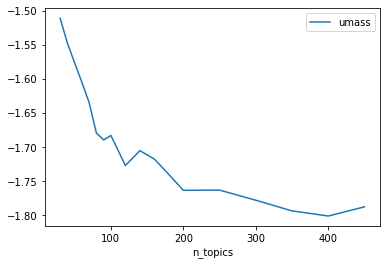

In [77]:
coherences_df.plot()

In [45]:
umass=coherences_df.umass.values
cnpmi=coherences_df.cnpmi.values

from scipy.stats import pearsonr

pearsonr(umass, cnpmi)

(-0.9888197186363983, 6.74450959430238e-08)

compared umass and cnpmi coherence for 10-100 n_topics models

* correlation: -0.9888197186363983
* p value: 6.74450959430238e-08

these values suggests it's ok to use umass as a quick coherence metric (highly correlated with much slower cnpmi)

In addition, cnpmi uses sliding window approach to evaluate models. As we don't want to discard long range relationships in speeches, this is undesirable, and so umass is in principle a better metric.

## plot histogram of document effective topics

In [51]:
from scipy.stats import entropy

In [47]:
n_vals = np.concatenate([
    np.arange(10, 100, 10),
    np.arange(100, 200, 20),
    np.arange(200, 451, 50) ])

In [49]:
inds = np.where(df.lemmas.apply(lambda x: len([w for w in x if w not in stopwords]) > 0).values)[0]

In [50]:
def make_probs(size, n_topics, p_topics=.6):
    if size < n_topics:
        return np.array([])
    else:
        return np.concatenate([np.repeat(p_topics/n_topics, n_topics), np.repeat( (1-p_topics)/(size-n_topics), (size-n_topics) )])

In [22]:
entropy(make_probs(8, 5), base=2)

2.9980924516755487

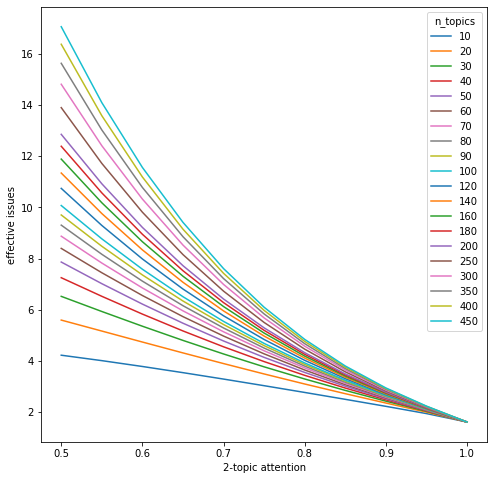

In [52]:
plt.figure(figsize=(8,8))

for size in n_vals:
    S = np.array([entropy(make_probs(size, 2, x)) for x in np.linspace(0.5, 1, 11)])
    I_eff = 2**S
    plt.plot(np.linspace(0.5, 1, 11), I_eff, label=size)
plt.xlabel('2-topic attention')
plt.ylabel('effective issues')
plt.legend(title='n_topics')
plt.show()

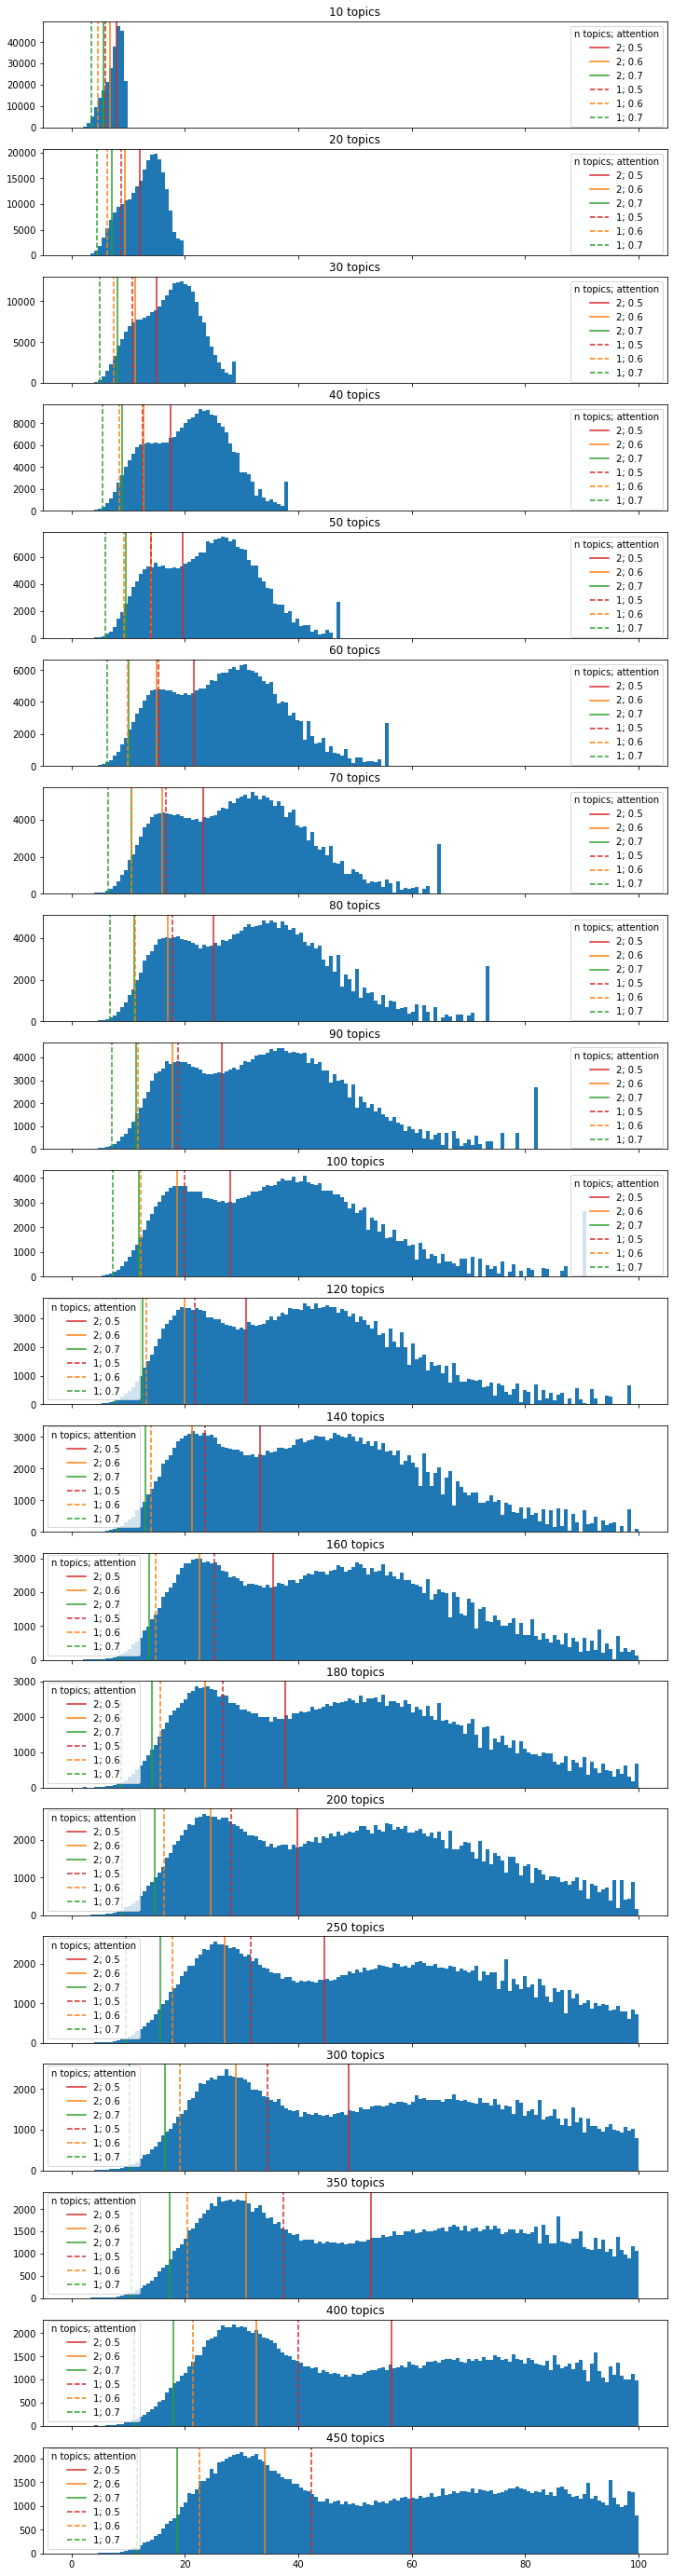

In [56]:
fig, ax = plt.subplots(len(n_vals),1, sharex=True, figsize=(12, 50))

for i, n in enumerate(n_vals):
    with open(f'topic-models/lda_mallet_{n}_doc_topics.pkl', 'rb') as f:
        doc_topic_dist = pickle.load(f)
    
    doc_entropy = entropy(doc_topic_dist[inds], base=2, axis=1)
    ax[i].hist(2**doc_entropy, bins=np.linspace(0,100,51*3))
    
    cs = ['tab:red', 'tab:orange', 'tab:green']
    ts = [0.5, 0.6, 0.7]
    
    ns = [2, 1]
    styles = ['solid', 'dashed']
    for n_topics, style in zip(ns, styles):
        for c, t in zip(cs, ts):
            I_eff_thresh = 2**entropy(make_probs(n, n_topics, t), base=2)
            ax[i].axvline(I_eff_thresh, c=c, 
                          label=f'{n_topics}; {t}', linestyle=style)
        
    ax[i].set_title(f'{n} topics')
    ax[i].legend(title='n topics; attention')
    
plt.show()

In [119]:
doc_topic_dist = doc_topic_dists[100]
doc_entropy_100 = entropy(doc_topic_dist[inds], base=2, axis=1)

In [149]:
high_S_inds = np.where(2**doc_entropy_100 > 93.01)[0]

In [158]:
low_S_inds = np.argsort(doc_entropy_100)[:500]

In [161]:
df.iloc[inds].iloc[top_S_inds].sample(30).reset_index().lemmas

0           [hon, lady, way]
1       [go, withdraw, bill]
2                 [tory, mp]
3         [dodge, use, word]
4            [get, question]
5      [hon, gentleman, way]
6     [grateful, get, point]
7                  [benefit]
8     [centrally, prescribe]
9                   [scared]
10                [shocking]
11           [toby, perkins]
12           [fully, inform]
13    [home, secretary, way]
14       [indicate, dissent]
15      [absolute, nonsense]
16        [hon, friend, way]
17     [complete, agreement]
18     [hon, gentleman, way]
19                 [rubbish]
20            [order, sorry]
21         [speak, shocking]
22               [reopening]
23                [grateful]
24                    [good]
25     [hon, gentleman, way]
26        [hon, friend, way]
27     [hon, gentleman, way]
28                [possible]
29     [wrong, hairdressing]
Name: lemmas, dtype: object

In [166]:
for x in df.iloc[inds].iloc[low_S_inds].sample(20).reset_index().speech:
    print(f'{x}\n')

I am deeply saddened by the divisions and upset that this issue has caused to people on both sides of the argument. Sadly, in some quarters the divisions arise because the debate has been characterised as bigoted religion on the one hand versus equality on the other. Neither of those is true. True Christians are not bigoted, and this is not a matter of equality, no matter how often it is referred to as equal marriage. Some of the divisions arise from the campaign to steer people into thinking that marriage is simply about love and commitment. It could also be said that the Bill falls foul of Parliament’s convention of not legislating retrospectively, because changing the fundamental nature of marriage will affect existing marriages.Under the law as it stands, as tested in the European Court of Human Rights, civil partnerships are equal to marriage. They might not have the same name, but they are equal. It has been argued that society views marriage and civil partnerships as being diffe

In [167]:
lemmas_len = df.lemmas.apply(len).values

In [170]:
len(lemmas_len)

253820

In [175]:
len(doc_entropy_100)

250322

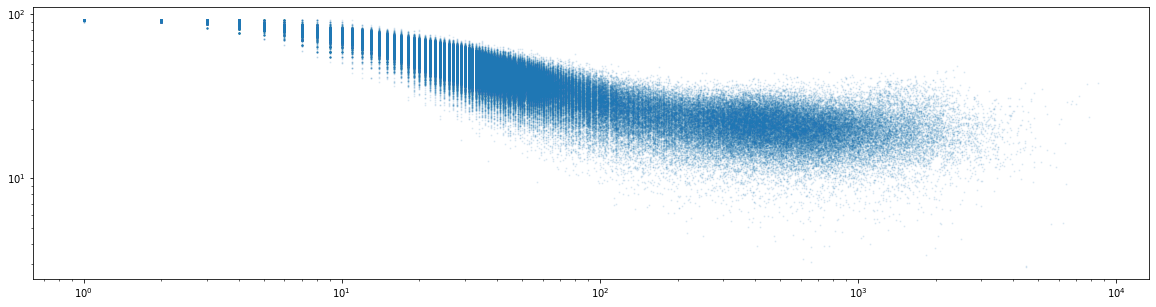

In [183]:
plt.figure(figsize=(20, 5))
plt.scatter(lemmas_len[inds], 2**doc_entropy_100, s=1, alpha=0.1)
plt.xscale('log')
plt.yscale('log')

## examine topics

In [58]:
gensim_lda_models[40].print_topics(-1)

[(0,
  '0.053*"member" + 0.049*"issue" + 0.041*"debate" + 0.033*"point" + 0.026*"important" + 0.023*"concern" + 0.020*"raise" + 0.016*"hope" + 0.013*"matter" + 0.011*"hear"'),
 (1,
  '0.050*"work" + 0.032*"gentleman" + 0.032*"ensure" + 0.027*"important" + 0.024*"lady" + 0.022*"support" + 0.016*"continue" + 0.016*"good" + 0.015*"point" + 0.015*"absolutely"'),
 (2,
  '0.064*"committee" + 0.025*"house" + 0.025*"member" + 0.019*"report" + 0.015*"parliament" + 0.013*"select" + 0.012*"public" + 0.011*"commission" + 0.011*"proposal" + 0.010*"change"'),
 (3,
  '0.067*"woman" + 0.020*"abuse" + 0.015*"man" + 0.012*"violence" + 0.012*"victim" + 0.011*"issue" + 0.011*"domestic" + 0.010*"support" + 0.009*"work" + 0.009*"sexual"'),
 (4,
  '0.038*"constituency" + 0.027*"constituent" + 0.016*"petition" + 0.011*"community" + 0.009*"year" + 0.009*"area" + 0.009*"resident" + 0.008*"port" + 0.008*"house" + 0.008*"fishing"'),
 (5,
  '0.014*"bbc" + 0.013*"great" + 0.013*"sport" + 0.012*"year" + 0.011*"world

In [ ]:
coherences = []
for n, cm in coherence_models.items():
    coherences.append(cm.get_coherence())
    print(f'done {n}')

done 10


In [ ]:
plt.plot(coherences)

In [58]:
i = np.random.randint(0, len(corpus))
doc_i = corpus[i]

print(df.iloc[i].speech)

print(texts[i][:10])

n_topics_print = 5
doc_i_topics = np.argsort(doc_topics[i])[::-1][:n_topics_print]
doc_i_probs = np.sort(doc_topics[i])[::-1][:n_topics_print]
print(doc_i_topics)
print(doc_i_probs)

Order. People can take whatever view they like, but, to be fair, the Secretary of State is always an estimably courteous individual in the Chamber, and we must hear the fella. There has been much reference to the Procedure Committee, of which the hon. Member for Gainsborough (Sir Edward Leigh) is of course a distinguished ornament. Order. I will call a very small number of Members now, but colleagues will also have an opportunity to question the Prime Minister, who is always very committed to the House. Order. I am sorry to disappoint remaining colleagues. My normal practice is to call everybody, but there are constraints of time and we must now move on. People will have the opportunity to question the Prime Minister.
['order', 'people', 'view', 'like', 'fair', 'secretary', 'state', 'estimably', 'courteous', 'individual']
[47 29  8 48 17]
[0.21649485 0.06185567 0.05154639 0.04123711 0.03092784]


In [59]:
model.print_topic(47)

'0.078*"order" + 0.053*"mr" + 0.047*"speaker" + 0.041*"point" + 0.037*"house" + 0.037*"hon" + 0.034*"member" + 0.030*"question" + 0.024*"gentleman" + 0.022*"matter"'

In [57]:
model.print_topic(2)

'0.020*"government" + 0.014*"fail" + 0.013*"time" + 0.012*"bad" + 0.012*"today" + 0.010*"lose" + 0.010*"face" + 0.009*"leave" + 0.009*"simply" + 0.009*"day"'

In [60]:
from scipy.stats import entropy

doc_i_S = entropy(doc_i_probs, base=2)

2**doc_i_S

3.726678069858574

In [71]:
doc_entropy = entropy(doc_topics, base=2, axis=1)

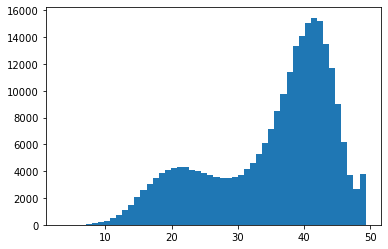

In [111]:
plt.hist(2**(doc_entropy[np.where(df.lemmas.str.len() != 0)]), bins=50)
plt.show()

In [127]:
S_inds = np.where(2**(doc_entropy[np.where(df.lemmas.str.len() != 0)]) > 49)
non_empty_inds = np.where(df.lemmas.str.len() != 0)

In [129]:
both_inds = np.union1d(S_inds, non_empty_inds)

In [131]:
df.iloc[both_inds].sample(10)

,,,speech,lemmas
date,heading,display_as,,
2016-02-04,Business of the House,Andy Slaughter,Does the Leader of the House detect any differ...,"[leader, house, detect, difference, view, euro..."
2019-03-11,CHILDREN ACT 1989 (AMENDMENT) (FEMALE GENITAL MUTILATION) BILL [LORDS],Lindsay Hoyle,"Order. We have 13 Members waiting to speak, an...","[order, member, wait, speak, minister, need, w..."
2012-02-09,LEADER OF THE HOUSE Statutory Register of Lobbyists,David Heath,The Government published our initial proposals...,"[government, publish, initial, proposal, form,..."
2019-02-14,BUSINESS OF THE HOUSE,Caroline Lucas,"Tomorrow, thousands of young people will show ...","[tomorrow, thousand, young, people, deep, conc..."
2018-07-05,TRANSFORMING CARE PROGRAMME,Jim Shannon,"I am sorry I was not here earlier, but I was i...","[sorry, early, hour, westminster, hall, debate..."
2019-05-15,SERIOUS VIOLENCE,Siobhain McDonagh,Does the Home Secretary agree that one way to ...,"[home, secretary, agree, way, gain, intelligen..."
2013-11-18,WORK AND PENSIONS Commonwealth Meeting and the Philippines,Pat McFadden,Given what happened at the end of the war in S...,"[give, happen, end, war, sri, lanka, happen, p..."
2016-10-19,RIGHTS OF EU NATIONALS,Robin Walker,I congratulate the Scottish National party on ...,"[congratulate, scottish, national, party, secu..."
2010-07-26,"CULTURE, MEDIA AND SPORT Creative Partnerships",Ben Bradshaw,Successive Labour Culture Secretaries achieved...,"[successive, labour, culture, secretaries, ach..."


In [109]:
np.array(corpus)[np.where(df.lemmas.str.len() == 0)]

<ipython-input-109-004e481a8b63>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(corpus)[np.where(df.lemmas.str.len() == 0)]


array([list([]), list([]), list([]), ..., list([]), list([]), list([])],
      dtype=object)

In [105]:
(df.lemmas.str.len() != 0).loc['2010-05-25']

date        heading                                            display_as      
2010-05-25  DEPUTY SPEAKERS Debate on the Address — [1st Day]  Alan Beith           True
                                                               Alan Haselhurst      True
                                                               Andrew Miller        True
                                                               Andrew Selous        True
                                                               Andrew Smith         True
                                                                                   ...  
            DISSOLUTION OF PARLIAMENT                          Julian Lewis         True
                                                               Martin Horwood       True
                                                               Michael Connarty     True
                                                               Peter Bone           True
                              

In [133]:
12*60/40

18.0